In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import glob
import re
#import xmltodict
import pickle
import untangle
import uuid
from tqdm import tqdm
from decimal import Decimal
from skimage import measure, morphology
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.segmentation import clear_border
from skimage.filters import roberts, sobel


from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [40]:
import pylidc as pl

In [46]:
qu = pl.query(pl.Scan).filter(pl.Scan.slice_thickness <= 1)
print(qu.count())
# => 97

scan = qu.first()
print(scan.patient_id, scan.pixel_spacing, scan.slice_thickness)
# => LIDC-IDRI-0066, 0.63671875, 0.6

print(len(scan.annotations))
# => 11

print(scan.get_path_to_dicom_files())

97
LIDC-IDRI-0066 0.63671875 0.6
11
/kaggle_2/lidc_idri/data/LIDC/DOI/LIDC-IDRI-0066/1.3.6.1.4.1.14519.5.2.1.6279.6001.143774983852765282237869625332/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410


Loading dicom files ... This may take a moment.


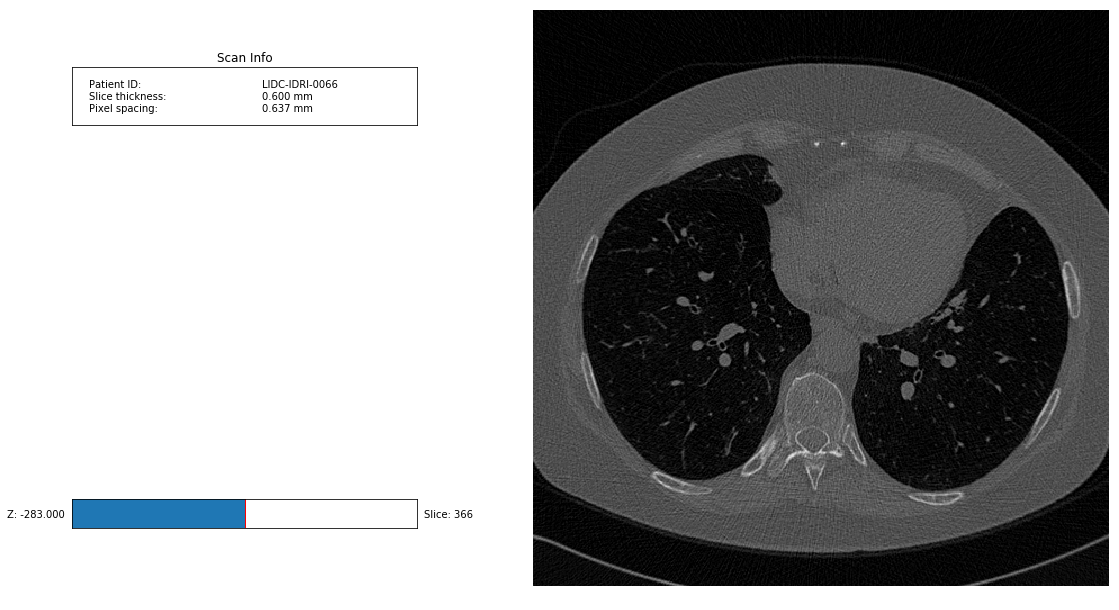

In [42]:
scan.visualize()

In [57]:
ann = scan.annotations[0]
print(ann.scan.patient_id)
# => LIDC-IDRI-0066

print(ann.spiculation, ann.Spiculation())
# => 3, Medium Spiculation

print(ann.estimate_diameter(), ann.estimate_volume())
# => 15.4920358194, 888.052284241

from pylidc.Annotation import feature_names as fnames
fvals, fstrings = ann.feature_vals(return_str=True)
print(fnames[0].title(), fstrings[0], fvals[0])
# => Subtlety, Obvious, 5

LIDC-IDRI-0066
3 Medium Spiculation
15.4920358194 888.052284241
Subtlety Obvious 5


Loading dicom files ... This may take a moment.


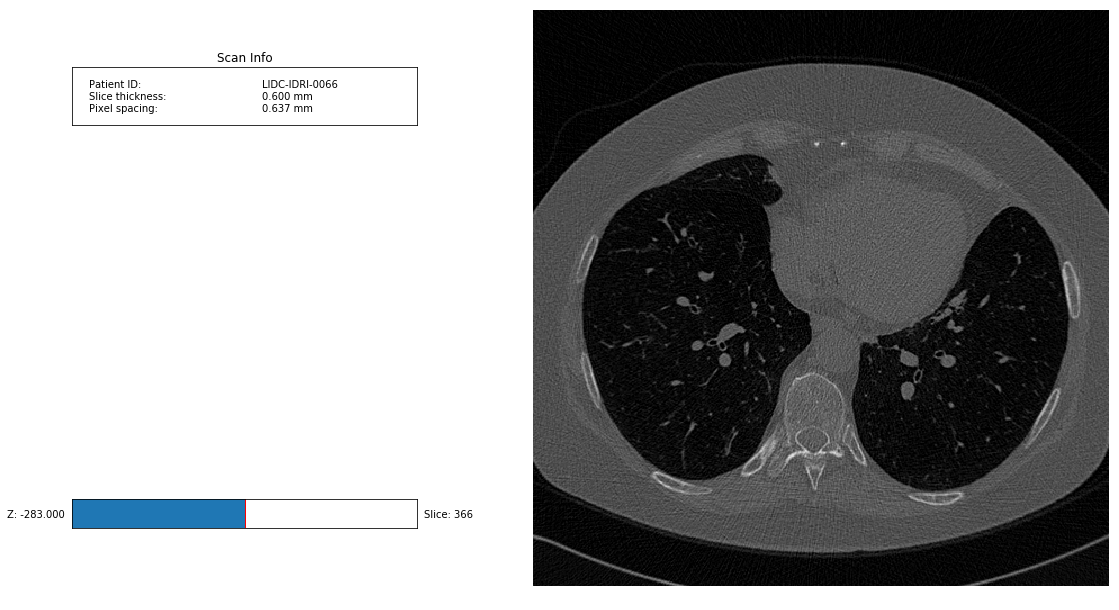

In [61]:
scan.visualize()

In [62]:
print(ann.contours_to_matrix().shape)
# => (671, 3)

print(ann.contours_to_matrix().mean(axis=0) - ann.centroid())
# => [ 0.  0.  0.]

(1754, 3)
[ 0.  0.  0.]


Loading dicom files ... This may take a moment.


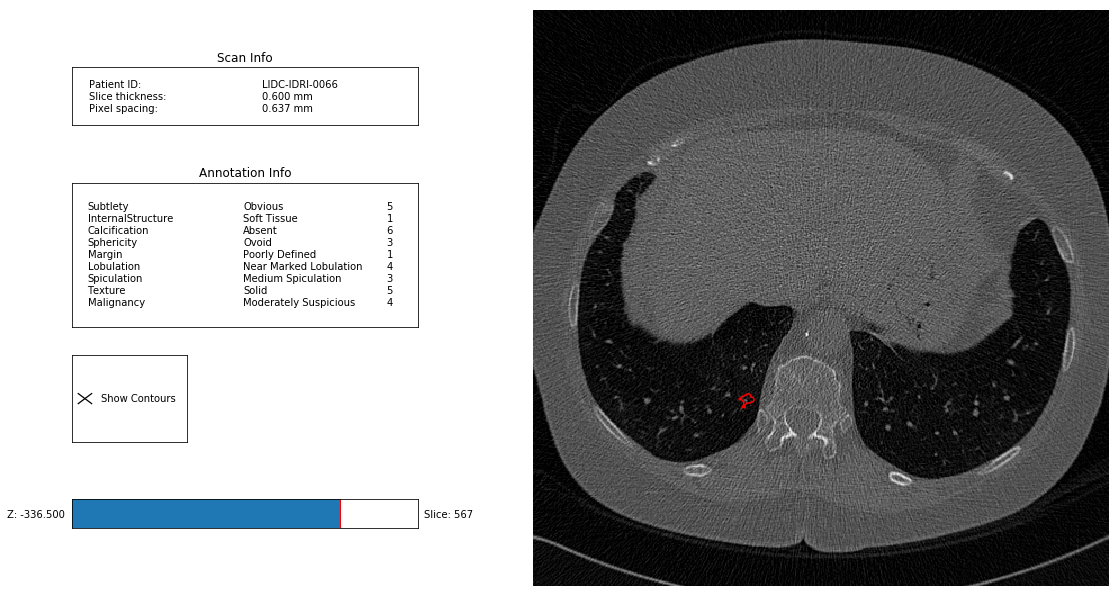

In [63]:
ann.visualize_in_scan()

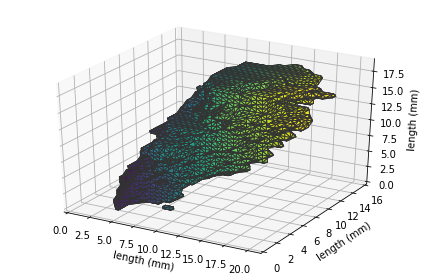

In [64]:
ann.visualize_in_3d()

Loading dicom files ... This may take a moment.
(101, 101, 101) (101, 101, 101)


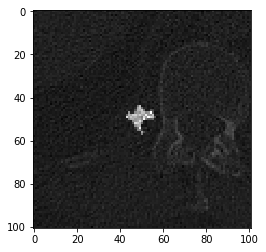

In [65]:
vol, seg = ann.uniform_cubic_resample(side_length = 100)
print(vol.shape, seg.shape)
# => (101, 101, 101) (101, 101, 101)

import matplotlib.pyplot as plt
plt.imshow( vol[:,:,50] * (seg[:,:,50]*0.8 + 0.2), cmap=plt.cm.gray)
plt.show()

In [66]:
from sqlalchemy import func
scan = pl.query(pl.Scan).filter(pl.Scan.contrast_used == True).order_by(func.random()).first()
ann  = pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 5).order_by(func.random()).first()

## For Debugging

In [68]:
from sqlalchemy import func
scan = pl.query(pl.Scan).filter(pl.Scan.contrast_used == True).order_by(func.random()).first()
ann  = pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 5).order_by(func.random()).first()

In [69]:
anns = pl.query(pl.Annotation).join(pl.Scan).filter(pl.Scan.slice_thickness < 1, pl.Annotation.malignancy != 3)

In [70]:
ann = pl.query(pl.Annotation).first()
vol, seg = ann.uniform_cubic_resample(side_length = 100)
print(vol.shape, seg.shape)
# => (101, 101, 101) (101, 101, 101)

import matplotlib.pyplot as plt
plt.imshow( vol[:,:,50] * (seg[:,:,50]*0.8 + 0.2), cmap=plt.cm.gray)
plt.show()

Loading dicom files ... This may take a moment.


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle_2/lidc_idri/data/LIDC/DOI/LIDC-IDRI-0078/1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277323131167631068432/1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102183795724852353824/000000.dcm'

In [71]:
ann.scan.get_path_to_dicom_files()

'/kaggle_2/lidc_idri/data/LIDC/DOI/LIDC-IDRI-0078/1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277323131167631068432/1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102183795724852353824'